In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import MobileNet, ResNet50, InceptionV3
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.models import Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [2]:
path = r"C:/Users/DELL/OneDrive/Documents/3-Credits Project/Dataset/"
im_size = 224
leaf_types = ['earlyblight', 'Healthy', 'LateBlight']
images = []
labels = []

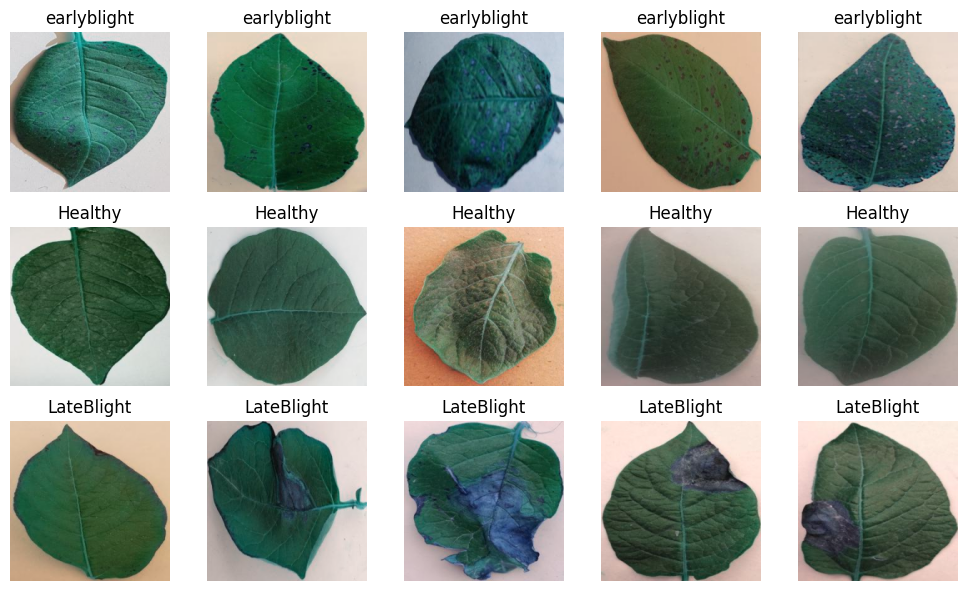

In [3]:
def visualize_samples(leaf_types, path, num_samples=5):
    plt.figure(figsize=(10, 6))
    for i, leaf_type in enumerate(leaf_types):
        data_path = os.path.join(path, leaf_type)
        filenames = os.listdir(data_path)[:num_samples]
        for j, filename in enumerate(filenames):
            img_path = os.path.join(data_path, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (im_size, im_size))
            plt.subplot(len(leaf_types), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(leaf_type)
    plt.tight_layout()
    plt.show()

visualize_samples(leaf_types, path)

In [4]:
for leaf_type in leaf_types:
    data_path = os.path.join(path, leaf_type)
    filenames = [f for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f))]
    for filename in filenames:
        img_path = os.path.join(data_path, filename)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (im_size, im_size))
        images.append(img)
        labels.append(leaf_type)

In [5]:
images = np.array(images) / 255.0
labels = np.array(labels)

In [6]:
print("Shape of images:", images.shape)
print("Shape of labels:", labels.shape)

Shape of images: (4072, 224, 224, 3)
Shape of labels: (4072,)


In [7]:
def visualize_class_distribution(labels):
    unique, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(8, 5))
    plt.bar(unique, counts)
    plt.xlabel('Leaf Types')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution')
    plt.xticks(rotation=45)
    plt.show()

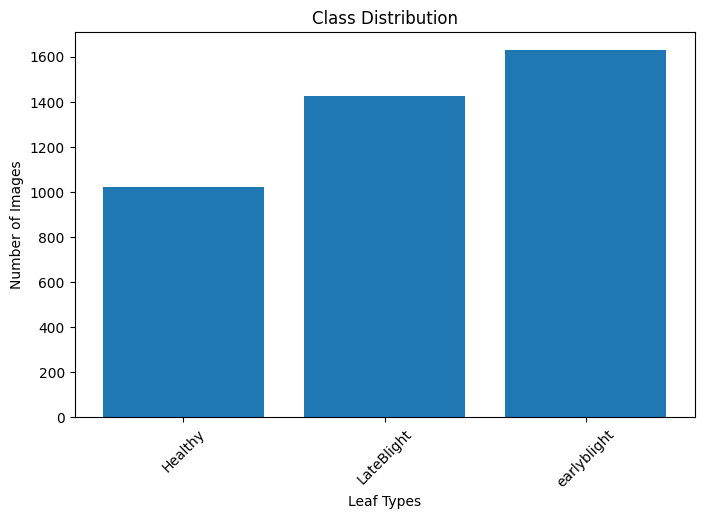

In [8]:
visualize_class_distribution(labels)


In [9]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [10]:
train_images, val_images, train_labels, val_labels = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)

In [11]:
print("Train images shape:", train_images.shape)
print("Validation images shape:", val_images.shape)
print("Train labels shape:", train_labels.shape)
print("Validation labels shape:", val_labels.shape)

Train images shape: (3257, 224, 224, 3)
Validation images shape: (815, 224, 224, 3)
Train labels shape: (3257,)
Validation labels shape: (815,)


LOADING THE PRE-TRAINED MODELS

In [12]:
mobilenet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

Create Models to Extract Features

In [13]:
mobilenet_feature_extractor = Model(inputs=mobilenet_model.input, outputs=mobilenet_model.output)
resnet_feature_extractor = Model(inputs=resnet_model.input, outputs=resnet_model.output)
inception_feature_extractor = Model(inputs=inception_model.input, outputs=inception_model.output)

In [14]:
def extract_features(images, model, preprocess_func):
    preprocessed_images = preprocess_func(images)
    features = model.predict(preprocessed_images)
    return features

In [15]:
train_mobilenet_features = extract_features(train_images, mobilenet_feature_extractor, mobilenet_preprocess)
train_resnet_features = extract_features(train_images, resnet_feature_extractor, resnet_preprocess)
train_inception_features = extract_features(train_images, inception_feature_extractor, inception_preprocess)

102/102 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 527s 5s/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 421s 4s/step


In [16]:
val_mobilenet_features = extract_features(val_images, mobilenet_feature_extractor, mobilenet_preprocess)
val_resnet_features = extract_features(val_images, resnet_feature_extractor, resnet_preprocess)
val_inception_features = extract_features(val_images, inception_feature_extractor, inception_preprocess)

26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 875ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 110s 4s/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step


In [17]:
def flatten_and_merge_features(mobilenet_features, resnet_features, inception_features):
    mobilenet_features = mobilenet_features.reshape((mobilenet_features.shape[0], -1))
    resnet_features = resnet_features.reshape((resnet_features.shape[0], -1))
    inception_features = inception_features.reshape((inception_features.shape[0], -1))
    combined_features = np.concatenate([mobilenet_features, resnet_features, inception_features], axis=1)
    return combined_features

In [18]:
train_combined_features = flatten_and_merge_features(train_mobilenet_features, train_resnet_features, train_inception_features)
val_combined_features = flatten_and_merge_features(val_mobilenet_features, val_resnet_features, val_inception_features)

In [19]:
print("Shape of train combined features:", train_combined_features.shape)
print("Shape of validation combined features:", val_combined_features.shape)

Shape of train combined features: (3257, 201728)
Shape of validation combined features: (815, 201728)


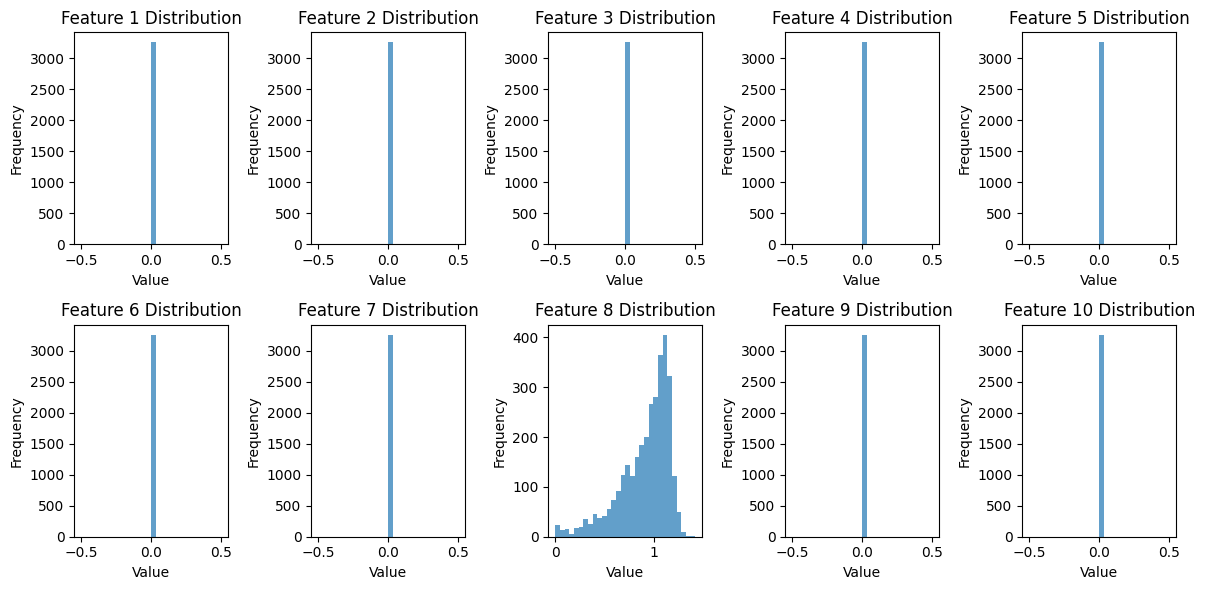

In [20]:
def visualize_feature_distribution(features, num_features=10):
    plt.figure(figsize=(12, 6))
    for i in range(num_features):
        plt.subplot(2, num_features // 2, i + 1)
        plt.hist(features[:, i], bins=30, alpha=0.7, label=f'Feature {i+1}')
        plt.title(f'Feature {i+1} Distribution')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

visualize_feature_distribution(train_combined_features)

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
train_combined_features_reduced = pca.fit_transform(train_combined_features)
val_combined_features_reduced = pca.transform(val_combined_features)


In [22]:
print("Shape of train combined features after PCA:", train_combined_features_reduced.shape)
print("Shape of validation combined features after PCA:", val_combined_features_reduced.shape)

Shape of train combined features after PCA: (3257, 100)
Shape of validation combined features after PCA: (815, 100)


In [23]:
def train_and_evaluate_classifier(classifier, train_features, train_labels, val_features, val_labels):
    classifier.fit(train_features, train_labels)
    val_predictions = classifier.predict(val_features)
    accuracy = accuracy_score(val_labels, val_predictions)
    return accuracy

In [24]:
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(kernel='linear', random_state=42)
}

In [25]:
accuracies = {}

for name, clf in classifiers.items():
    accuracy = train_and_evaluate_classifier(clf, train_combined_features_reduced, train_labels, val_combined_features_reduced, val_labels)
    accuracies[name] = accuracy
    print(f"{name} accuracy: {accuracy:.4f}")

Random Forest accuracy: 0.7350
KNN accuracy: 0.6724
SVM accuracy: 0.7718


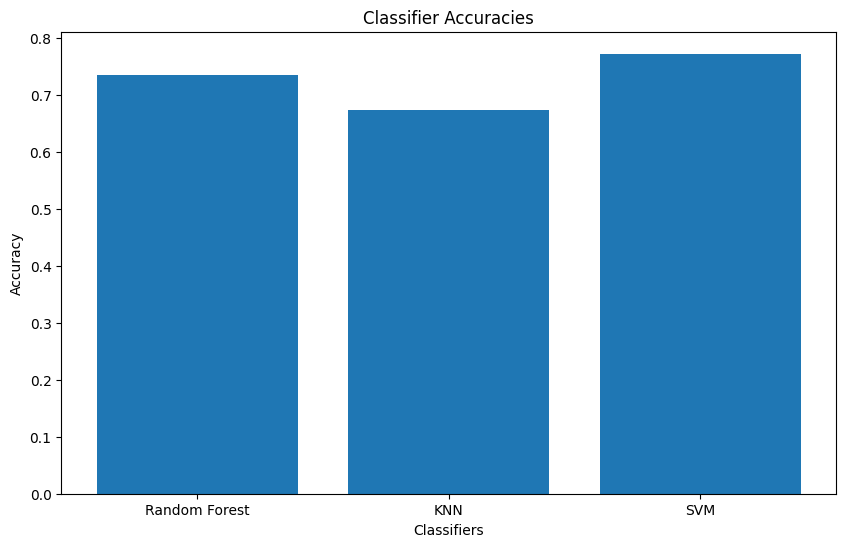

In [26]:
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values())
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Classifier Accuracies')
plt.show()